In [ ]:
!pip install pingouin

     |████████████████████████████████| 182 kB 5.1 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |████████████████████████████████| 9.8 MB 34.8 MB/s 
  Created wheel for pingouin: filename=pingouin-0.5.0-py3-none-any.whl size=193661 sha256=5a71ea97c9e32fa1b8b80228cf36fa14e12476aba03b9a760734c2517d702188
  Stored in directory: /root/.cache/pip/wheels/14/46/f9/cedd81d68d2515c24bbbd000d5b347e4fe092ccc4b568f7f70
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=e260c052c68d71f863c5a63b641cf709acf80d35b892d856647270dbc4c259f1
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built pingouin littleutils
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsm

# Configuration

In [ ]:
S = ('Very Low', 'Low', 'Middle', 'High', 'Very High')

In [ ]:
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
from scipy.stats import ks_2samp, shapiro, ttest_rel, wilcoxon
import random
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint as pp
import pingouin as pg

In [ ]:
%matplotlib inline

In [ ]:
plt.rcParams["figure.figsize"]=(20,5)
sns.set_theme(style='white', palette="viridis")

## Functions 

In [ ]:
#@title Basic fuzzy functions {display-mode: "form"}

labelValue = lambda x: S.index(x)

labelMax = lambda x,y: S[max(labelValue(x), labelValue(y))]
labelMin = lambda x,y: S[min(labelValue(x), labelValue(y))]
neg = lambda x: S[len(S) - labelValue(x)  - 1]

In [ ]:
#@title Fuzzy Quantifier {display-mode: "form"}
def most(x, li = 0.3, ls = 0.8, exp=1.0):
  if x < li: 
    return 0
  elif x >= ls :
    return 1
  else:
    return  ((x - li) / (ls - li))**exp

In [ ]:
#@title Support function {display-mode: "form"}
def support(I, alpha=1):
  sup = []
  for i in I:
    sup.append(sum([1 for j in I if abs(labelValue(i) - labelValue(j)) < alpha]))
  return sup

In [ ]:
#@title Majority Guided IOWA {display-mode: "form"}
def MLIOWAPond(I, P):
  '''
    MLIOWAPond: S x S --> S
    I: importance degree
    P: expert's opinion
  '''
  # Induced Order
  U = (np.array(support(I, alpha=1)) + np.array([labelValue(i) for i in I])) / 2
  Us, Ps = zip(*sorted(zip(U, P), key = lambda t: t[0]))
  # Weights
  # Error if most = 0 --> division by 0
  # Use implication
  W_aux = list(map(most,np.array(Us)/len(Us)))
  W = np.array(W_aux) / sum(W_aux)
  IndPs = list(map(labelValue, Ps))
  k = sum(np.array(W) * np.array(IndPs))
  return S[round(k)]

In [ ]:
#@title Numeric T-norms{display-mode: "form"}
def tnorm_min(a,b):
  return min(a,b)

def tnorm_product(a,b):
  return a*b

def tnorm_lukasiewicz(a,b):
  return max(0, a+b-1)

def tnorm_drastic(a,b):
  return a if b == 1 else ( b if a == 1 else 0)

tnorm = {
    'min': tnorm_min,
    'product': tnorm_product,
    'lukasiewicz': tnorm_lukasiewicz
}

In [ ]:
#@title Distance between orders {display-mode: "form"}
def mean_abs_diff(A, B):
  difs = [abs(A[x] - B[x]) for x in A if x in B]
  return np.array(difs).mean()

def mean_diff_squared(A,B):
  difs = [(A[x] - B[x])**2 for x in A if x in B]
  return np.array(difs).mean()

def totality_diference(A,B):
  A_tot = len(set(A.values())) / len(set(A.keys()))
  B_tot = len(set(B.values())) / len(set(B.keys()))
  return abs(A_tot - B_tot)

order_distances = {
    'mean_abs_diff': mean_abs_diff,
    'mean_diff_squared': mean_diff_squared,
    'totality_diference': totality_diference
}

In [ ]:
#@title Order Metrics {display-mode: "form"}
def totality(A):
  return len(set(A.values())) / len(set(A.keys()))

order_metrics={
    'totality': totality
}

## Aggregation

In [ ]:
# Apply expert importance to each
def aggregate(df, experts_importance):
  agg_func = lambda x : MLIOWAPond(experts_importance, x)
  dfagg = df.groupby('Id').aggregate({'index':sum,
                            'Complexity':agg_func,
                            'Reusability':agg_func,
                            'Importance':agg_func})
  dfagg = dfagg.drop('index', 1)
  return dfagg

##Prioritization

In [ ]:
def prioritize(opinion_matrix, tnorm, dimensions_weights = None):

  comparison_mu =  lambda x: 1 if labelValue(x[0]) >= labelValue(x[1]) else (0.5 if labelValue(x[0]) == (labelValue(x[1]) - 1) else 0)

  indexes = opinion_matrix.index.values
  global_comparison_matrix = []
  order_reqs = {}

  for column in opinion_matrix.columns:
    # Cross product
    cross_product = list(itertools.product(opinion_matrix[column],opinion_matrix[column]))
    # Comparison matrix
    comparison_matrix = np.array(list(map(comparison_mu, cross_product)))
    
    # Let's consider that each dimension is equally important. 

    # Ponderate according to dimension
    if dimensions_weights is not None: 
      if type(list(dimensions_weights.values())[0]) in [float, int]:
        comparison_matrix = comparison_matrix ** dimensions_weights[column]
      else:
        pond = 1 - ((labelValue(dimensions_weights[column]) + 1)  / len(S))
        comparison_matrix = np.where(comparison_matrix < pond, pond, comparison_matrix)

    # Global comparison matrix (T-norm min)
    if len(global_comparison_matrix) == 0:
      global_comparison_matrix = comparison_matrix
    else:
      tnormv = np.vectorize(tnorm)
      global_comparison_matrix = tnormv(global_comparison_matrix, comparison_matrix)

  # Reshape: turn vector into matrix
  dim = int(len(indexes))
  global_comparison_matrix = global_comparison_matrix.reshape((dim,dim))
  # Extrict relation
  strict_relation = global_comparison_matrix - global_comparison_matrix.T
  strict_relation[strict_relation < 0] = 0 

  # Non dominance vector
  while len(indexes) > 0:
    non_dominance_vector = 1 - np.amax(strict_relation, 0)
    non_dominated = np.where(non_dominance_vector == max(non_dominance_vector))
    # get non dominated requirements
    order = len(order_reqs) + 1
    for r in list(indexes[non_dominated]):
      order_reqs[r] = order
    # remove non_dominated from matrix and indexes
    indexes = np.delete(indexes, non_dominated)
    strict_relation = np.delete( np.delete(strict_relation, non_dominated, 0), non_dominated, 1)
    

  return order_reqs

# Experiments

In [ ]:
def random_dataset(n_reqs, n_dim):
  return pd.DataFrame({str(i) : random.choices(S, k= n_reqs) for i in range(n_dim)})

In [ ]:
def evaluate(distance, metric, tnorms, iter = 100, n_reqs = 100, n_dims = 10, dimensions_weights = None):
  distances = {}
  metrics = {}
  for i in tqdm(range(iter)):
    # Create random dataset
    df = random_dataset(n_reqs, n_dims)

    evaluated_orders = {}

    # For each t-norm 
    for t in tnorms.keys():
      # Get the prioritization using the t-norm
      order = prioritize(df, tnorms[t], dimensions_weights)
      
      # Calculate the metric value for the order
      if t not in metrics.keys():
        metrics[t] = []
      metrics[t].append(metric(order))

      # Calculate the distance of the current order to the orders calculated before
      # using other t-norms
      for evaluated_key in evaluated_orders.keys():
        d = distance(order, evaluated_orders[evaluated_key])
        distance_key = "{}-{}".format(t, evaluated_key) 
        if distance_key not in distances.keys():
          distances[distance_key] = []
        distances[distance_key].append(d)
      evaluated_orders[t] = order

  return pd.DataFrame(distances), pd.DataFrame(metrics)
      

# Tests

In [ ]:
def wilcoxon_test(df, alter='two-sided', verbose=False):
  values = {}
  for c1 in df.columns:
    for c2 in df.columns:
      if not c1 == c2:
         w = pg.wilcoxon(df[c1], y = df[c2], alternative=alter, zero_method='zsplit')
         values[(c1,c2)] = w
         if verbose:
           if alter == 'two-sided':
             print("HA: {}{}{}".format(c1,'==', c2))
           elif alter == 'greater':
             print("HA: {}{}{}".format(c1,'>', c2))
           else:
             print("HA: {}{}{}".format(c1,'<', c2))
           print(w)           
  df_values = pd.concat(values.values(), keys=values.keys())
  #df_values.drop('toremove', axis=1, inplace=True)
  return df_values

# Runs

In [ ]:
distances = {}
metrics = {}
for i in tqdm(range(3,11)):
  distances[str(i)], metrics[str(i)] = evaluate(
    distance = order_distances['mean_abs_diff'],
    metric = order_metrics['totality'], 
    tnorms = tnorm, 
    iter = 300, 
    n_reqs = 100, 
    n_dims = i)
    

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
df_distances = pd.concat(distances, axis=0, names=('Dimensions', 'Index'))
df_metrics = pd.concat(metrics, axis=0, names=('Dimensions', 'Index'))

In [ ]:
df_distances.to_csv('distances.csv', sep=';')
df_metrics.to_csv('metrics.csv', sep=';')

## Comparisons

In [ ]:
df_distances = pd.read_csv('distances.csv', sep=';', index_col=[0,1])
df_metrics = pd.read_csv('metrics.csv', sep=';', index_col=[0,1])

In [ ]:
df_distances

product-min  lukasiewicz-min  lukasiewicz-product
Dimensions Index                                                   
3          0             6.59             7.23                 2.36
           1             4.61             5.46                 3.97
           2             8.70             7.95                 3.89
           3             5.95             6.24                 3.93
           4             5.28             5.26                 2.82
...                       ...              ...                  ...
10         295           4.60            23.26                24.40
           296           0.81            19.32                19.17
           297           4.27            22.35                23.08
           298           1.16            20.66                20.98
           299           0.30            18.70                18.92

[2400 rows x 3 columns]

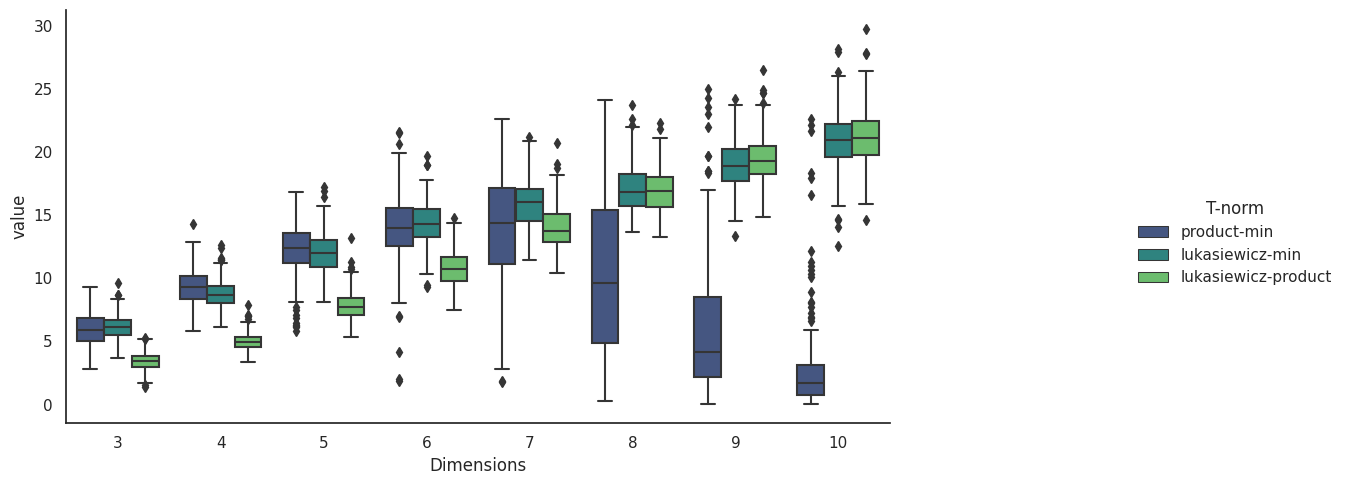

In [ ]:
df_distances_plot = df_distances.melt(var_name='T-norm', ignore_index=False).reset_index()
p = sns.catplot(data=df_distances_plot, x= 'Dimensions', y='value', hue='T-norm', kind='box', palette= sns.color_palette("viridis", 3))
p.fig.set_size_inches(15, 5)
p.fig.set_dpi(100)
p.savefig('distance.svg')

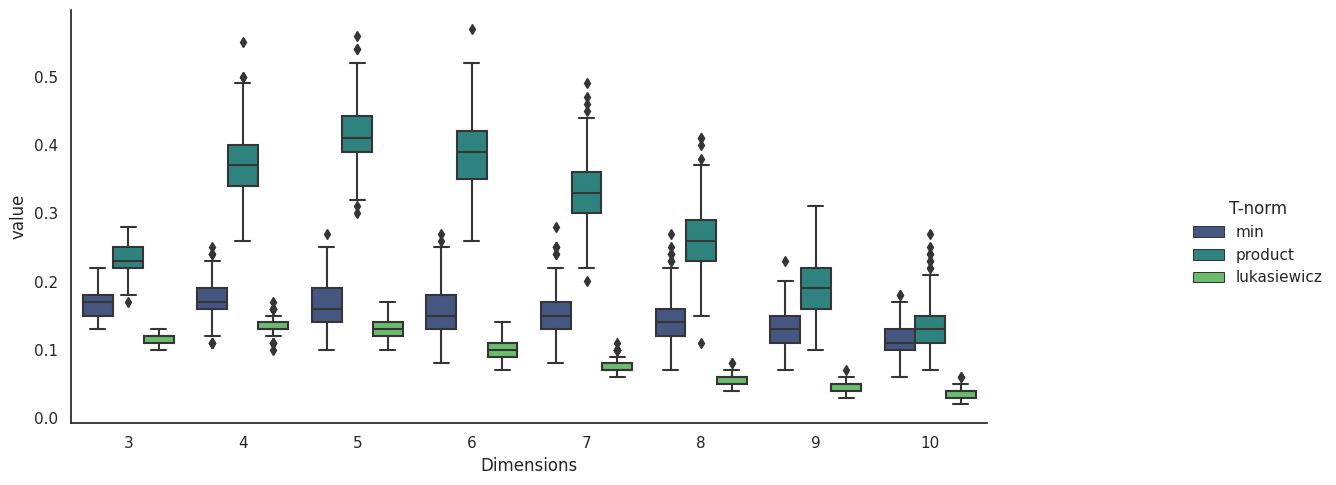

In [ ]:
df_metrics_plot = df_metrics.melt(var_name='T-norm', ignore_index=False).reset_index()
q = sns.catplot(data=df_metrics_plot, x= 'Dimensions', y='value', hue='T-norm', kind='box', palette= sns.color_palette("viridis", 3))
q.fig.set_size_inches(15, 5)
q.fig.set_dpi(100)
q.savefig('totality.svg')

# Hypothesis test

In [ ]:
wilcoxon_test(df_metrics, alter='greater')

W-val alternative  ...       RBC      CLES
min         product     Wilcoxon     9272.0     greater  ... -0.999992  0.116926
            lukasiewicz Wilcoxon  2875044.0     greater  ...  0.997276  0.877522
product     min         Wilcoxon  2871928.0     greater  ...  0.999992  0.883074
            lukasiewicz Wilcoxon  2881200.0     greater  ...  1.000000  0.970211
lukasiewicz min         Wilcoxon     6156.0     greater  ... -0.997276  0.122478
            product     Wilcoxon        0.0     greater  ... -1.000000  0.029789

[6 rows x 5 columns]

In [ ]:
dims = {}
for i in range(3,11):
  dims[i] = wilcoxon_test(df_metrics.loc[i], alter='greater')
wilcoxon_by_dim = pd.concat(dims.values(), keys=dims.keys(), names=('Dimensions', 'Metric1', 'Metric2', 'toremove'))
wilcoxon_by_dim

W-val  ...      CLES
Dimensions Metric1     Metric2     toremove           ...          
3          min         product     Wilcoxon      0.0  ...  0.005994
                       lukasiewicz Wilcoxon  45150.0  ...  0.997317
           product     min         Wilcoxon  45150.0  ...  0.994006
                       lukasiewicz Wilcoxon  45150.0  ...  1.000000
           lukasiewicz min         Wilcoxon      0.0  ...  0.002683
                       product     Wilcoxon      0.0  ...  0.000000
4          min         product     Wilcoxon      0.0  ...  0.000000
                       lukasiewicz Wilcoxon  44769.0  ...  0.916289
           product     min         Wilcoxon  45150.0  ...  1.000000
                       lukasiewicz Wilcoxon  45150.0  ...  1.000000
           lukasiewicz min         Wilcoxon    381.0  ...  0.083711
                       product     Wilcoxon      0.0  ...  0.000000
5          min         product     Wilcoxon      0.0  ...  0.000000
                       lukasiewicz Wilcoxon  43411.5  ...  0.851506
           product     min         Wilcoxon  45150.0  ...  1.000000
                       lukasiewicz Wilcoxon  45150.0  ...  1.000000
           lukasiewicz min         Wilcoxon   1738.5  ...  0.148494
                       product     Wilcoxon      0.0  ...  0.000000
6          min         product     Wilcoxon      0.0  ...  0.000067
                       lukasiewicz Wilcoxon  45033.0  ...  0.964500
           product     min         Wilcoxon  45150.0  ...  0.999933
                       lukasiewicz Wilcoxon  45150.0  ...  1.000000
           lukasiewicz min         Wilcoxon    117.0  ...  0.035500
                       product     Wilcoxon      0.0  ...  0.000000
7          min         product     Wilcoxon      0.0  ...  0.001222
                       lukasiewicz Wilcoxon  45149.5  ...  0.997450
           product     min         Wilcoxon  45150.0  ...  0.998778
                       lukasiewicz Wilcoxon  45150.0  ...  1.000000
           lukasiewicz min         Wilcoxon      0.5  ...  0.002550
                       product     Wilcoxon      0.0  ...  0.000000
8          min         product     Wilcoxon     28.5  ...  0.030828
                       lukasiewicz Wilcoxon  45150.0  ...  0.999761
           product     min         Wilcoxon  45121.5  ...  0.969172
                       lukasiewicz Wilcoxon  45150.0  ...  1.000000
           lukasiewicz min         Wilcoxon      0.0  ...  0.000239
                       product     Wilcoxon      0.0  ...  0.000000
9          min         product     Wilcoxon    451.5  ...  0.117150
                       lukasiewicz Wilcoxon  45150.0  ...  0.999989
           product     min         Wilcoxon  44698.5  ...  0.882850
                       lukasiewicz Wilcoxon  45150.0  ...  1.000000
           lukasiewicz min         Wilcoxon      0.0  ...  0.000011
                       product     Wilcoxon      0.0  ...  0.000000
10         min         product     Wilcoxon   4935.0  ...  0.306144
                       lukasiewicz Wilcoxon  45150.0  ...  0.999989
           product     min         Wilcoxon  40215.0  ...  0.693856
                       lukasiewicz Wilcoxon  45150.0  ...  1.000000
           lukasiewicz min         Wilcoxon      0.0  ...  0.000011
                       product     Wilcoxon      0.0  ...  0.000000

[48 rows x 5 columns]

In [ ]:
wilcoxon_by_dim.to_csv('wilcoxon_by_dimension.csv')

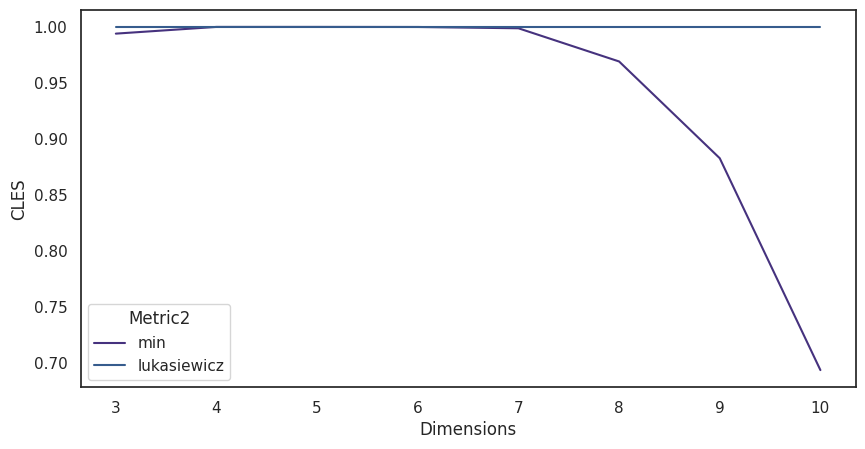

In [ ]:
r = sns.lineplot(data=filt.loc[filt['Metric1'] == 'product'], x='Dimensions', y='CLES', hue='Metric2')
fig = r.get_figure()
fig.set_size_inches(10, 5)
fig.set_dpi(100)
fig.savefig('CLES_product.svg')
r